# Loading Sharadar Daily Bundle for Running the Zipline Pipeline

The notebook demonstrates and tests the [fsharadar](https://flounderteam.github.io/fsharadar/) interface for running the [Zipline-based research platform](https://flounderteam.github.io/) with the Sharadar Daily bundle (ingested with the daily_ingest notebook within this repository). The corresponding example consists of five steps: building the pipeline engine, building pipeline, running it, reading the Sharadar files for comparison with pipeline data, and testing pipeline data.

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Importing the fsharadar.daily module from the Flounder extension

In [2]:
import fsharadar
from fsharadar import daily

## 1. Connecting the Daily Data Bundle with  Pipeline Engine

Loading Sharadar daily bundle

In [3]:
daily_bundle_data = daily.load()

Defining bundle-specific pipeline loader

In [4]:
pipe_loader = fsharadar.get_pipeline_loader(daily_bundle_data)

def get_pipe_loader(column):
    if column in daily.Fundamentals.columns:
        return pipe_loader
    raise ValueError("No PipelineLoader registered for column %s." % column)

Defining the Zipline pipeline engine

In [5]:
from zipline.pipeline.engine import SimplePipelineEngine

engine = SimplePipelineEngine(
    get_loader=get_pipe_loader,
    asset_finder=daily_bundle_data.asset_finder,
)

## 2. Building and Running Pipeline

Reviewing characteristics of the bundle-specific FundamentalsDataSet

In [6]:
daily.Fundamentals.columns

frozenset({FundamentalsDataSet<US>.currency::object,
           FundamentalsDataSet<US>.ev::float64,
           FundamentalsDataSet<US>.evebit::float64,
           FundamentalsDataSet<US>.evebitda::float64,
           FundamentalsDataSet<US>.marketcap::float64,
           FundamentalsDataSet<US>.pb::float64,
           FundamentalsDataSet<US>.pe::float64,
           FundamentalsDataSet<US>.ps::float64})

Defining the pipeline

In [7]:
from zipline.pipeline import Pipeline

pipe = Pipeline(
    columns={
        'ev': daily.Fundamentals.ev.latest,
        'evebit': daily.Fundamentals.evebit.latest,  
        'evebitda': daily.Fundamentals.evebitda.latest,   
        'marketcap': daily.Fundamentals.marketcap.latest,  
        'pb': daily.Fundamentals.pb.latest, 
        'pe': daily.Fundamentals.pe.latest,   
        'ps': daily.Fundamentals.ps.latest,           
    },
)

Running the pipeline

In [8]:
start_date = "2010-12-31"; end_date = "2021-07-30"

In [9]:
%%time
pipe_df = engine.run_pipeline(
    pipe,
    pd.Timestamp(start_date, tz='utc'),
    pd.Timestamp(end_date, tz='utc')
)

CPU times: user 13.8 s, sys: 3.28 s, total: 17.1 s
Wall time: 10.9 s


In [10]:
pipe_df.head(2)

ev  evebit  evebitda  \
2010-12-31 00:00:00+00:00 Equity(101286 [TUXS])   -3.3     6.3       6.6   
                          Equity(101501 [BBUCQ])  18.4    -9.4     -34.5   

                                                  marketcap   pb   pe    ps  
2010-12-31 00:00:00+00:00 Equity(101286 [TUXS])         1.1  0.1 -2.0  29.7  
                          Equity(101501 [BBUCQ])        0.0  0.0  0.0   0.0

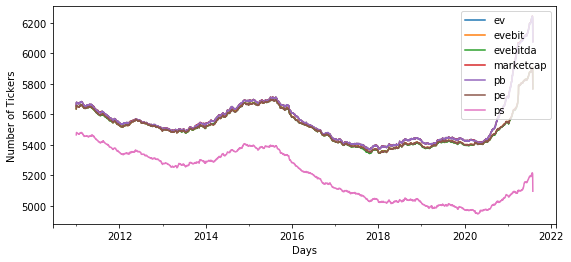

In [11]:
pipe_df.groupby(level=0).count().plot(figsize=(9, 4))
plt.xlabel('Days')
plt.ylabel('Number of Tickers')
plt.show()

In [12]:
print(len(pipe_df.index.get_level_values(1).unique()))

9692


## 3. Loading Sharadar files for testing pipeline data

In [13]:
sharadar_dir = './'

Tickers

In [14]:
sharadar_tickers_file = sharadar_dir + "SHARADAR_TICKERS.csv"

In [15]:
# read tickers_file (with sids)
tickers_df = pd.read_csv(sharadar_tickers_file)
print(len(tickers_df.ticker.unique()))

24992


Daily fundamentals

In [16]:
sharadar_daily_file = sharadar_dir + "SHARADAR_DAILY.csv"

In [17]:
%%time
from fsharadar.read import read_data_file

daily_df = read_data_file(sharadar_daily_file, tickers_df, fsharadar.daily.bundle_tags)
print(len(daily_df.symbol.unique()))

15712
CPU times: user 37.2 s, sys: 3.95 s, total: 41.2 s
Wall time: 41.9 s


## 4. Testing pipeline data

Selecting dates between start_date and end_date and shifting the start_date (in Zipline, PipelineReader shifted data 'that would be known at the start of each date')

In [18]:
from zipline.pipeline.domain import US_EQUITIES

sessions = US_EQUITIES.all_sessions()
sessions = sessions.tz_localize(None)

start_index = sessions.get_loc(start_date)
end_index = sessions.get_loc(end_date)

shifted_dates = sessions[start_index-1: end_index+1]
empty_shifted_df = pd.DataFrame(index=shifted_dates)

print(start_date, shifted_dates[0])

2010-12-31 2010-12-30 00:00:00


Swaping the date and symbol levels in the multi-index dataframes

In [19]:
%%time

pipe_df.index = pipe_df.index.swaplevel(0,1)
pipe_df = pipe_df.sort_index(level=0)

CPU times: user 19 s, sys: 4.79 s, total: 23.8 s
Wall time: 23.8 s


In [20]:
%%time

daily_df = daily_df.set_index(['symbol', 'date'])
daily_df = daily_df.sort_index(level=0)

CPU times: user 25.3 s, sys: 1min 11s, total: 1min 37s
Wall time: 1min 37s


The following code runs through all the assets and the bundle characteristics (e.g., marketcap) and checks for potential discrepencies between the time series from Zipline pipeline and Sharadar file. 

In [21]:
def check_asset(asset, daily_df, pipe_df):
    
    ticker = asset.symbol
    
    asset_daily_df = daily_df.xs(ticker)
    
    asset_shifted_df = empty_shifted_df.join(asset_daily_df)
    asset_shifted_df = asset_shifted_df.dropna(how='all')[:-1]  # shifting the end_date
    
    asset_pipe_df = pipe_df.xs(asset).dropna(how='all')
    
    std_diff = np.std(asset_shifted_df.values - asset_pipe_df.values)
    
    if std_diff > 1.e-9 : print(ticker, tag, std_diff)

In [22]:
from tqdm import tqdm

assets = pipe_df.index.get_level_values(0).unique()

for asset in tqdm(assets):
    check_asset(asset, daily_df, pipe_df)    

100%|██████████| 9692/9692 [00:21<00:00, 447.35it/s]
